In [48]:
import pandas as pd
import requests
import matplotlib.pyplot as plt
import io
import numpy as np
import plotly.express as px
import plotly.graph_objects as go

In [49]:
# Paso 1: Llamar la URL y obtener los datos
url = 'https://psl.noaa.gov/gcos_wgsp/Timeseries/Data/nino3.long.anom.data'
response = requests.get(url)
data = response.text

In [50]:
# Paso 2: Transformar los datos en un DataFrame
df = pd.read_csv(io.StringIO(data), delim_whitespace=True, header=None, skiprows=1)
df.columns = ['Year'] + [f'Month_{i+1}' for i in range(12)]


In [51]:
# Paso 4: Eliminar los valores de -99.99
df.replace(-99.99, pd.NA, inplace=True)
df = df.dropna()

In [52]:
# Convertir la columna 'Year' a enteros
df['Year'] = df['Year'].astype(int)

# Paso 3: Eliminar todas las filas después del año 2024
df = df[df['Year'] < 2024]

In [53]:
# Paso 5: Transformar los datos en 2 columnas
df_long = pd.melt(df, id_vars=['Year'], value_vars=[f'Month_{i+1}' for i in range(12)],
                  var_name='Month', value_name='Anomaly')

# Convertir 'Month' a un formato numérico y crear la columna 'Year-Month'
df_long['Month'] = df_long['Month'].str.extract('(\d+)').astype(int)
df_long['Year-Month'] = df_long.apply(lambda row: f"{row['Year']}-{row['Month']:02d}", axis=1)

# Seleccionar las columnas deseadas y ordenar por 'Year-Month'
df_final = df_long[['Year-Month', 'Anomaly']].sort_values('Year-Month').reset_index(drop=True)

# Convertir las columnas 'Year-Month' y 'Anomaly' a los tipos adecuados
df_final['Year-Month'] = df_final['Year-Month'].astype(str)
df_final['Anomaly'] = df_final['Anomaly'].astype(float)

# Guardar el DataFrame final para su revisión
df_final.to_csv('nino3.4_anomalies.csv', index=False)

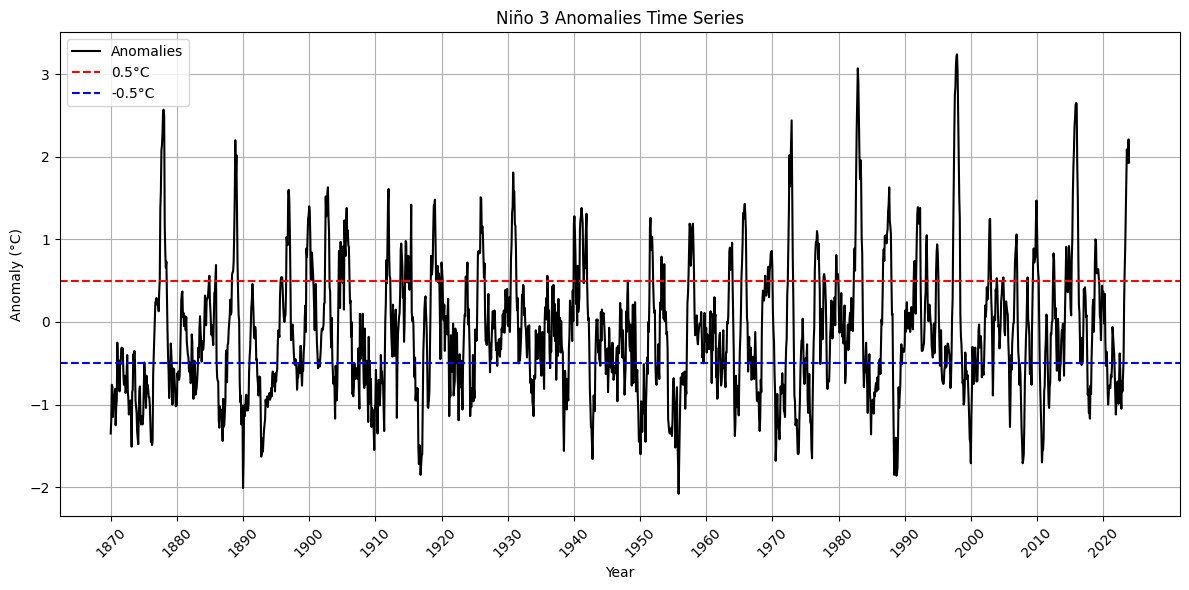

In [54]:
# Paso 6: Generar una gráfica de la serie de tiempo
plt.figure(figsize=(12, 6))
plt.plot(df_final['Year-Month'], df_final['Anomaly'], color='black', label='Anomalies')
plt.axhline(y=0.5, color='red', linestyle='--', label='0.5°C')
plt.axhline(y=-0.5, color='blue', linestyle='--', label='-0.5°C')
plt.xlabel('Year')
plt.ylabel('Anomaly (°C)')
plt.title('Niño 3 Anomalies Time Series')

# Ajustar el eje x para mostrar solo las décadas
years = df_final['Year-Month'].str[:4].astype(int).unique()
decades = [year for year in years if year % 10 == 0]
plt.xticks([f"{decade}-01" for decade in decades], decades, rotation=45)

plt.legend()
plt.grid(True)
plt.tight_layout()

# Mostrar la gráfica
plt.show()

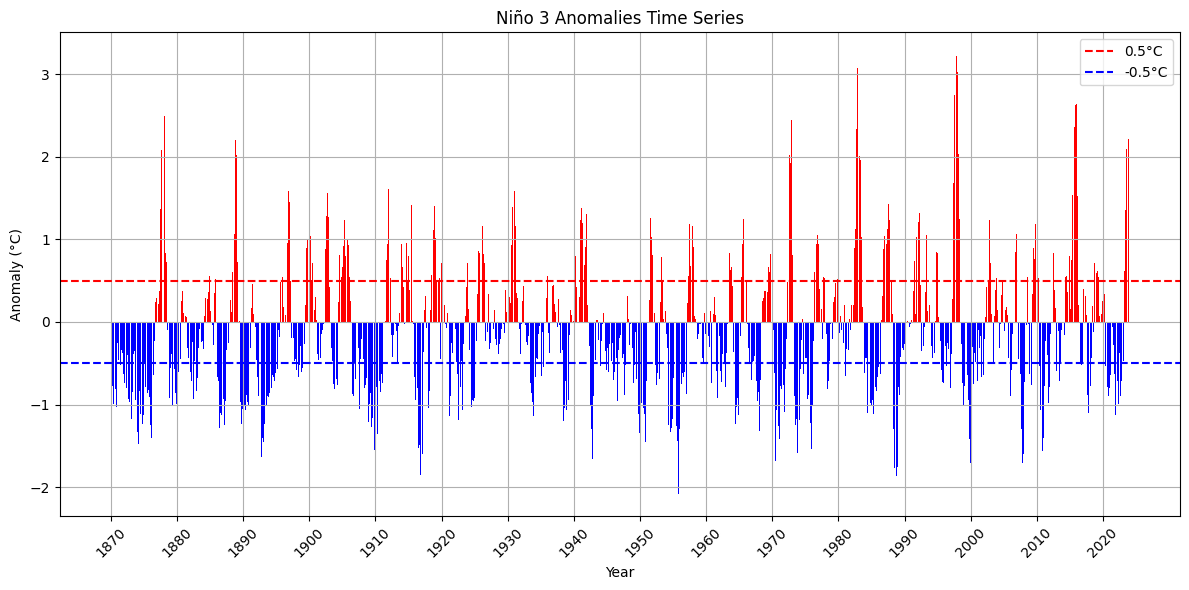

In [55]:
# Paso 6: Generar una gráfica de la serie de tiempo estilo NOAA
plt.figure(figsize=(12, 6))
bar_colors = np.where(df_final['Anomaly'] >= 0, 'red', 'blue')
plt.bar(df_final['Year-Month'], df_final['Anomaly'], color=bar_colors)
plt.axhline(y=0.5, color='red', linestyle='--', label='0.5°C')
plt.axhline(y=-0.5, color='blue', linestyle='--', label='-0.5°C')
plt.xlabel('Year')
plt.ylabel('Anomaly (°C)')
plt.title('Niño 3 Anomalies Time Series')

# Ajustar el eje x para mostrar solo las décadas
years = df_final['Year-Month'].str[:4].astype(int).unique()
decades = [year for year in years if year % 10 == 0]
plt.xticks([f"{decade}-01" for decade in decades], decades, rotation=45)

plt.legend()
plt.grid(True)
plt.tight_layout()

# Mostrar la gráfica
plt.show()

In [56]:
# Generar la gráfica de la serie de tiempo estilo NOAA con Plotly
fig = go.Figure()

# Agregar barras de anomalías
fig.add_trace(go.Bar(
    x=df_final['Year-Month'],
    y=df_final['Anomaly'],
    marker_color=['red' if val >= 0 else 'blue' for val in df_final['Anomaly']],
    hoverinfo='x+y',
))

# Agregar líneas horizontales en 0.5 y -0.5
fig.add_trace(go.Scatter(
    x=df_final['Year-Month'],
    y=[0.5] * len(df_final),
    mode='lines',
    line=dict(color='red', dash='dash'),
    name='0.5°C'
))

fig.add_trace(go.Scatter(
    x=df_final['Year-Month'],
    y=[-0.5] * len(df_final),
    mode='lines',
    line=dict(color='blue', dash='dash'),
    name='-0.5°C'
))

# Ajustar el eje x para mostrar solo las décadas
years = df_final['Year-Month'].str[:4].astype(int).unique()
decades = [year for year in years if year % 10 == 0]
fig.update_xaxes(tickvals=[f"{decade}-01" for decade in decades], ticktext=decades)

# Configurar el diseño de la gráfica
fig.update_layout(
    title='Niño 3 Anomalies Time Series',
    xaxis_title='Year',
    yaxis_title='Anomaly (°C)',
    showlegend=True,
    template='plotly_white',
    hovermode='x unified'
)

# Mostrar la gráfica interactiva
fig.show()